In [76]:
import pandas as pd
import numpy as np

data = "./car_soh_data.csv"
df = pd.read_csv(data)

In [77]:
# df.head(5)
df.describe()

,model_year,battery_capacity_kWh,electric_range_km_reported,power_kW,top_speed_kmh,mileage_km,price_eur,soh
count,335.000000,335.000000,335.000000,321.000000,332.000000,335.000000,335.000000,335.000000
mean,2021.689552,70.595821,444.546269,202.618380,175.677711,76785.074627,28433.641791,93.821493
std,1.657602,18.172666,106.128623,91.317022,29.664515,40165.768985,11339.220627,3.529230
min,2015.000000,1.000000,1.000000,1.000000,20.000000,1000.000000,5790.000000,76.100000
25%,2021.000000,62.000000,400.000000,150.000000,160.000000,48500.000000,20885.000000,92.050000
50%,2022.000000,77.000000,460.000000,170.000000,160.000000,71000.000000,28190.000000,94.200000
75%,2023.000000,82.000000,515.000000,258.000000,190.750000,102000.000000,33585.000000,96.200000
max,2025.000000,112.000000,668.000000,585.000000,261.000000,227000.000000,85780.000000,101.200000


In [78]:
# sample = df.sample(1).iloc[0]
# sample
df = df[df["vehicle_type"] == "PASSENGER_CAR"] # just passenger cars
len(df)
df["manufacturer"].value_counts()


manufacturer
Volkswagen       74
Tesla            35
Skoda            29
Polestar         24
BMW              23
Mercedes-Benz    22
Audi             19
Volvo            15
Hyundai          14
Kia              13
Opel             11
Nissan           10
Peugeot           9
Renault           8
MG                6
Toyota            3
Citroen           3
Ford              3
Porsche           2
Mini              2
Cupra             1
Subaru            1
Maxus             1
Seat              1
Dacia             1
Jaguar            1
Name: count, dtype: int64

In [79]:
df = df.copy()
df["workdays"] = (pd.to_datetime(df["purchase_date"]) - pd.to_datetime(df["first_usage_date"])).dt.days

In [80]:
df_analysis = df[["manufacturer", "manufacturer_and_model", "battery_capacity_kWh", "model_year", "workdays", "mileage_km", "soh"]]
df_analysis.head(5)

,manufacturer,manufacturer_and_model,battery_capacity_kWh,model_year,workdays,mileage_km,soh
0,Kia,Kia EV6,77.0,2022,1133,23000,98.1
1,Skoda,Skoda Enyaq,82.0,2022,1350,151000,90.7
2,Citroen,Citroen C4,50.0,2022,1186,35000,94.0
3,Kia,Kia EV9,99.8,2024,514,38000,98.8
4,Mercedes-Benz,Mercedes-Benz EQV,100.0,2022,1349,87000,97.3


In [81]:
# Cleaning SoH values

df_analysis = df_analysis[df_analysis["soh"] <= 100]
df_analysis = df_analysis[df_analysis["soh"] >= 0]

In [82]:
df_analysis = df_analysis.copy()
degradation = 100 - df_analysis["soh"]
df_analysis.loc[:, "degradation"] = degradation
# df_analysis["deg_per_1000km"] = (degradation / df_analysis["mileage_km"]) * 1000
df_analysis["deg_per_20000km"] = (degradation / df_analysis["mileage_km"]) * 20000
df_analysis["deg_per_365days"] = (degradation / df_analysis["workdays"]) * 365
df_analysis.head(5)

,manufacturer,manufacturer_and_model,battery_capacity_kWh,model_year,workdays,mileage_km,soh,degradation,deg_per_20000km,deg_per_365days
0,Kia,Kia EV6,77.0,2022,1133,23000,98.1,1.9,1.652174,0.612092
1,Skoda,Skoda Enyaq,82.0,2022,1350,151000,90.7,9.3,1.231788,2.514444
2,Citroen,Citroen C4,50.0,2022,1186,35000,94.0,6.0,3.428571,1.846543
3,Kia,Kia EV9,99.8,2024,514,38000,98.8,1.2,0.631579,0.852140
4,Mercedes-Benz,Mercedes-Benz EQV,100.0,2022,1349,87000,97.3,2.7,0.620690,0.730541


In [83]:
df_mean_deg = df_analysis.copy()
mean = df_mean_deg.groupby("manufacturer_and_model")["deg_per_20000km"].mean().reset_index()
mean

,manufacturer_and_model,deg_per_20000km
0,Audi Q4 e-tron,1.686403
1,Audi Q8 e-tron,1.068966
2,Audi e-tron,1.459804
3,BMW i3,3.717089
4,BMW i4,1.042385
...,...,...
68,Volkswagen ID.7,1.319588
69,Volkswagen Up!,4.271207
70,Volkswagen e-up!,2.705036
71,Volvo C40,1.395097


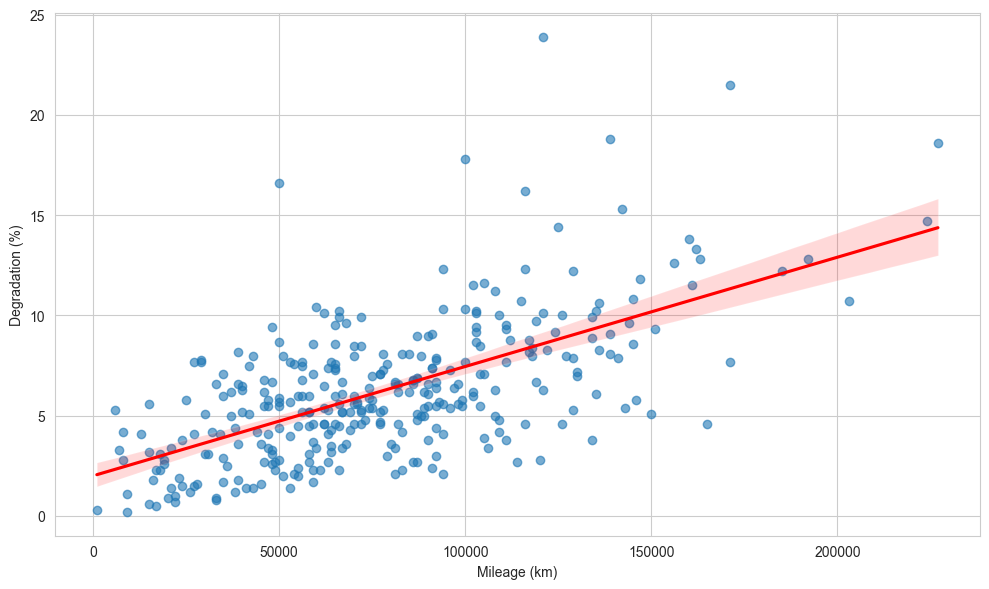

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_analysis,
    x="mileage_km",
    y="degradation",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
sns.set_style("whitegrid")

# plt.title("Battery Degradation vs Mileage", fontsize=12)
plt.xlabel("Mileage (km)")
plt.ylabel("Degradation (%)")
plt.tight_layout()


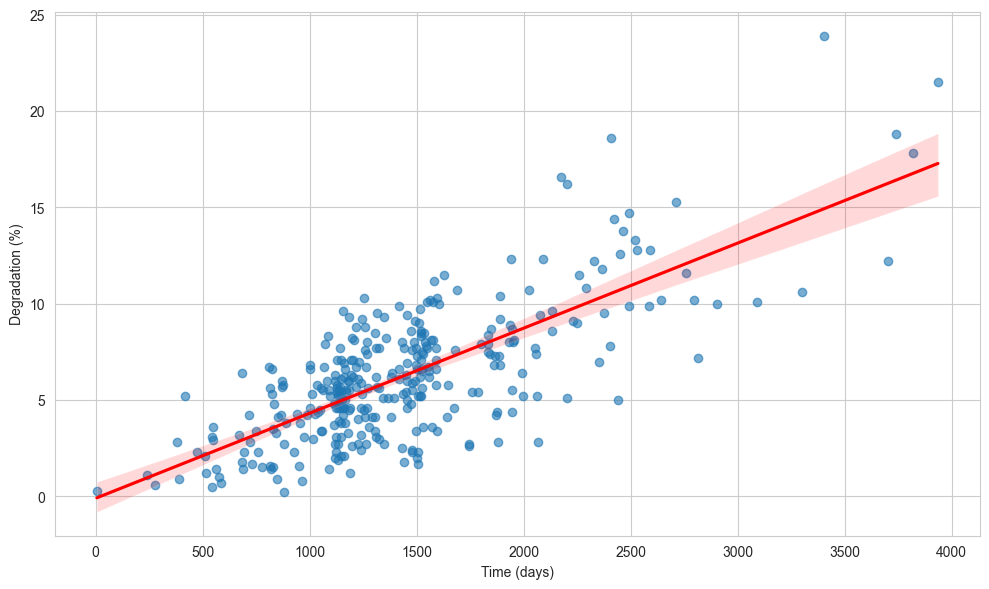

In [85]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_analysis,
    x="workdays",
    y="degradation",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
sns.set_style("whitegrid")

# plt.title("Battery Degradation vs Mileage", fontsize=12)
plt.xlabel("Time (days)")
plt.ylabel("Degradation (%)")
plt.tight_layout()

123.90275609756097
     manufacturer  time_mileage_index
0            Audi          102.870947
1             BMW          101.894652
2         Citroen           57.581000
3           Cupra           95.496000
4           Dacia           63.898000
5            Ford           91.971667
6         Hyundai          174.449357
7          Jaguar          332.050000
8             Kia           73.347077
9              MG           43.219167
10          Maxus           85.475000
11  Mercedes-Benz          122.453200
12           Mini           35.230500
13         Nissan          151.463800
14           Opel           72.751273
15        Peugeot           89.135889
16       Polestar           83.304708
17        Porsche           43.416000
18        Renault          195.956500
19           Seat          171.512000
20          Skoda          124.138897
21         Subaru           42.752000
22          Tesla          250.255914
23         Toyota           54.054000
24     Volkswagen          113.

C:\Users\hesam\AppData\Local\Temp\ipykernel_6508\1501417537.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped_mean = df_analysis_time_mileage.groupby("manufacturer")["time_mileage_index"].mean().reset_index()


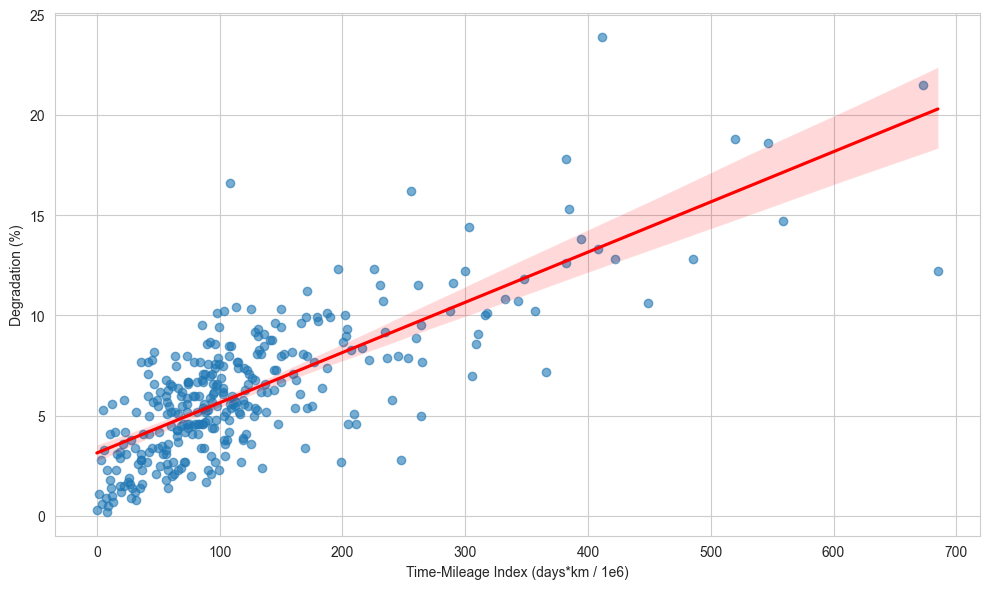

In [101]:
df_analysis_time_mileage = df_analysis.copy()
df_analysis_time_mileage["time_mileage_index"] = (df_analysis_time_mileage["workdays"] * df_analysis_time_mileage["mileage_km"]) / 1e6

df_mean = df_analysis_time_mileage["time_mileage_index"].mean()
print(df_mean)

df_grouped_mean = df_analysis_time_mileage.groupby("manufacturer")["time_mileage_index"].mean().reset_index()
print(df_grouped_mean)

plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_analysis_time_mileage,
    x="time_mileage_index",
    y="degradation",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
sns.set_style("whitegrid")
# plt.title("Battery Degradation vs Time-Mileage Index", fontsize=12)
plt.xlabel("Time-Mileage Index (days*km / 1e6)")
plt.ylabel("Degradation (%)")
plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

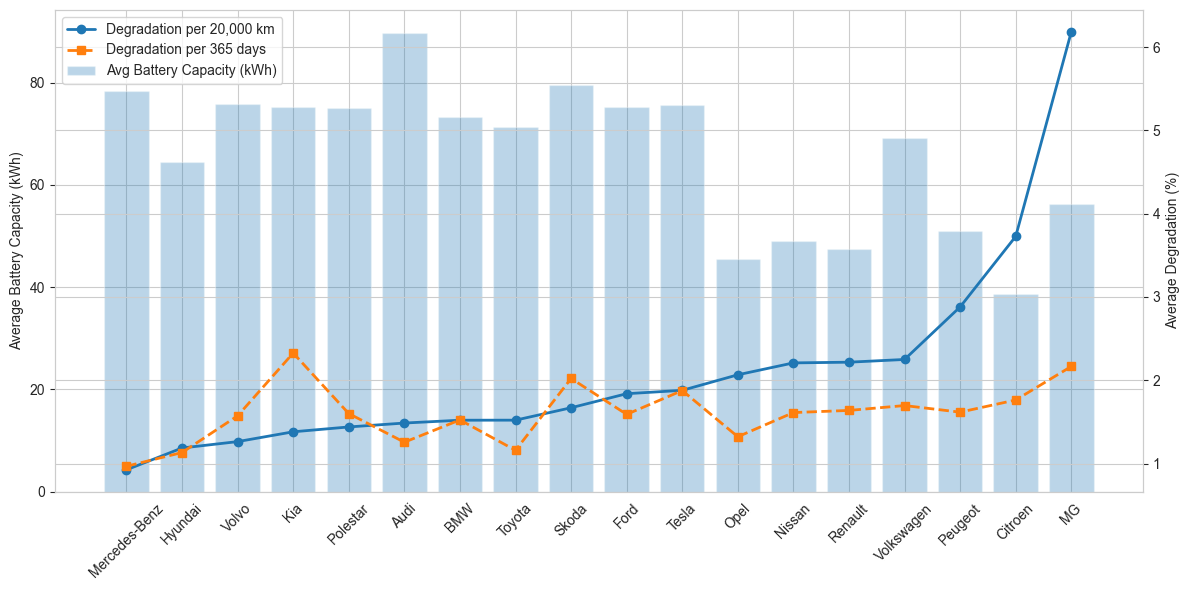

In [86]:
df_analysis_manufacturer = df_analysis.copy()

df_analysis_bymanufacturer = (
    df_analysis.groupby("manufacturer", observed=False)
    .agg(
        avg_degradation_per_20000km=("deg_per_20000km", "mean"),
        avg_battery_capacity_kWh=("battery_capacity_kWh", "mean"),
        avg_degradation_per_365days=("deg_per_365days", "mean"),
        # count=("deg_per_20000km", "size"),
    )
    .reset_index()
)


df_analysis_bymanufacturer = df_analysis_bymanufacturer[df_analysis_bymanufacturer["manufacturer"].map(df_analysis["manufacturer"].value_counts()) >= 3]

df_analysis_bymanufacturer_sorted = df_analysis_bymanufacturer.sort_values("avg_degradation_per_20000km", ascending=True)
plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")

df_plot = df_analysis_bymanufacturer.sort_values(
    "avg_degradation_per_20000km", ascending=True
)

x = np.arange(len(df_plot))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Degradation lines
ax2 = ax1.twinx()
ax2.plot(
    x,
    df_plot["avg_degradation_per_20000km"],
    marker='o',
    linewidth=2,
    label="Degradation per 20,000 km"
)
ax2.plot(
    x,
    df_plot["avg_degradation_per_365days"],
    marker='s',
    linewidth=2,
    linestyle='--',
    label="Degradation per 365 days"
)

# Battery Capacity
bars = ax1.bar(
    x,
    df_plot["avg_battery_capacity_kWh"],
    alpha=0.3,
    label="Avg Battery Capacity (kWh)"
)
ax1.set_ylabel("Average Battery Capacity (kWh)")
ax1.set_xticks(x)
ax1.set_xticklabels(df_plot["manufacturer"], rotation=45)



ax2.set_ylabel("Average Degradation (%)")
# plt.title("Battery Degradation vs Capacity by Manufacturer", fontsize=13)
lines, labels = ax2.get_legend_handles_labels()
bars, bar_labels = ax1.get_legend_handles_labels()
ax2.legend(lines + bars, labels + bar_labels, loc="upper left")

plt.tight_layout()
plt.show()


Average degradation per 20,000 km across all SoH groups: 1.90%


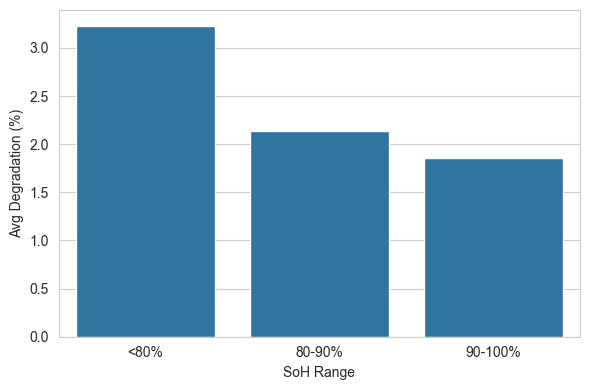

In [87]:
mean_soh_bins = df_analysis["deg_per_20000km"].mean()
print(f"Average degradation per 20,000 km across all SoH groups: {mean_soh_bins:.2f}%")

df_analysis["soh_group"] = pd.cut(
    df_analysis["soh"],
    bins=[0, 80, 90, 100],
    labels=["<80%", "80-90%", "90-100%"],
    include_lowest=True
)
soh_bins_mean = (
    df_analysis
    .groupby("soh_group", observed=True)["deg_per_20000km"]
    .mean()
    .reset_index()
)

sns.set_style("whitegrid")

plt.figure(figsize=(6,4))

sns.barplot(
    data=soh_bins_mean,
    x="soh_group",
    y="deg_per_20000km"
)

# plt.title("Average Degradation per 20,000 km by SoH Range")
plt.xlabel("SoH Range")
plt.ylabel("Avg Degradation (%)")

plt.tight_layout()
plt.show()



**LightGBM

In [88]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

df_analysis["manufacturer"] = (
    df_analysis["manufacturer"].astype("category")
)

X = df_analysis[[
    "manufacturer",
    "battery_capacity_kWh",
    "model_year",
    "workdays",
    "mileage_km",
]].copy()

y = df_analysis["soh"]

df_analysis["manufacturer"] = df_analysis["manufacturer"].astype("category")
cat_features = ["manufacturer"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train, categorical_feature=cat_features)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.05
,n_estimators,150
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [89]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

MAE: 1.73921461975798
R2: 0.6326120329448026
RMSE: 2.3360036740863874


In [90]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(
    model, X, y,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

print("CV MAE:", -mae_scores.mean())


CV MAE: 1.5198877079921242


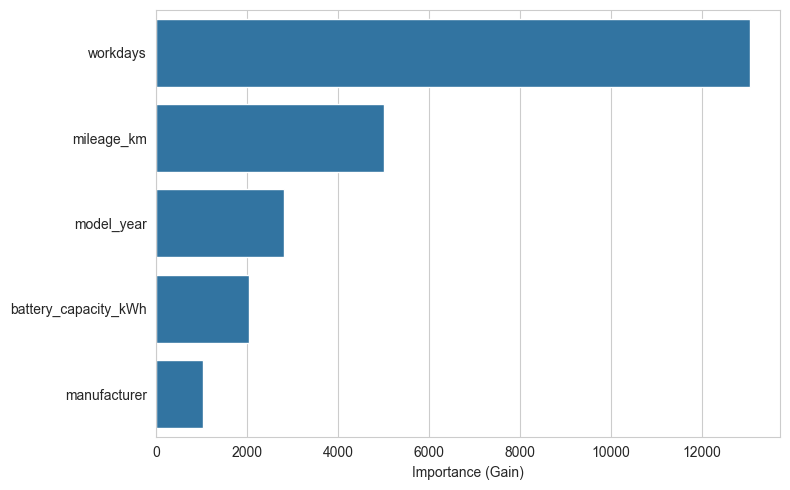

In [96]:
# Plot feature importance
# Extract importance manually
importance_df = pd.DataFrame({
    "feature": model.feature_name_,
    "importance": model.booster_.feature_importance(importance_type="gain")
})

# Sort
importance_df = importance_df.sort_values("importance", ascending=False)

# Style
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.barplot(
    data=importance_df,
    x="importance",
    y="feature"
)

# plt.title("Feature Importance (Gain)", fontsize=13)
plt.xlabel("Importance (Gain)")
plt.ylabel("")

plt.tight_layout()
plt.show()

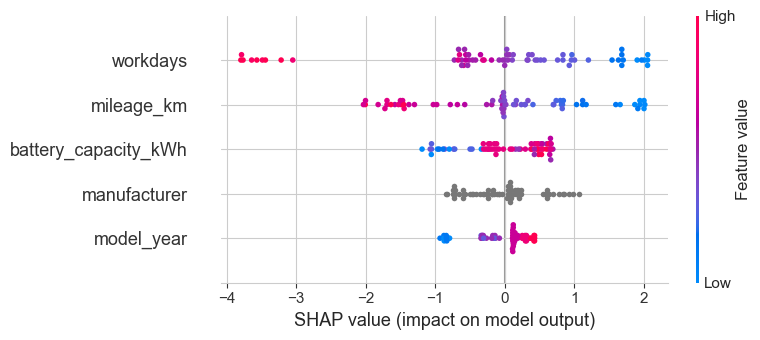

In [97]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


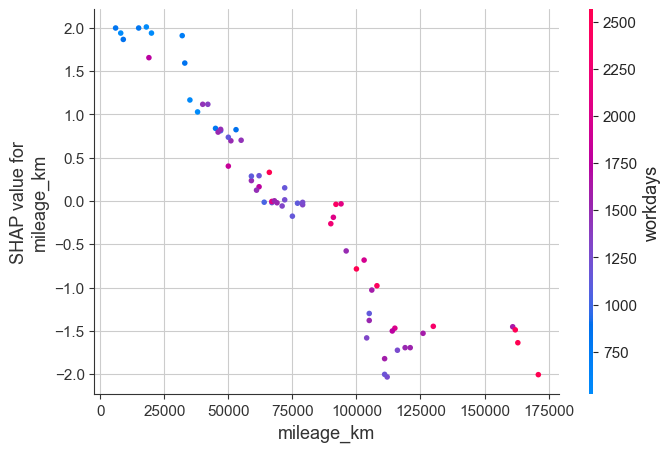

In [93]:
shap.dependence_plot(
    "mileage_km",
    shap_values,
    X_test
)
